In [2]:
# module Tst

using Infiltrator
using LinearAlgebra

include("./KjBandits.jl")



print_children_data (generic function with 1 method)

In [38]:
function problem_factory(
    problem_name::String, σ²::Real, alpha=1.0, Delta=0.1, seed::UInt32=987)
    if     problem_name == "linear"
        problem = Bandit(collect(0.9:-0.1:0.0), σ², seed)
    elseif     problem_name == "linear_K100"
        problem = Bandit(collect(LinRange(1,0,100)), σ², seed)
    elseif     problem_name == "linear_K20"
        problem = Bandit(collect(LinRange(1,0,20)), σ², seed)
    elseif problem_name == "linear_K2"
        problem = Bandit([0.9,0.5], σ², seed)
    elseif problem_name == "linear_K2_custom"
        problem = Bandit([0.9,0.3], σ², seed)
    elseif problem_name == "poly_K20"
        Delta_ary = ((1:20) ./ 20) .^ alpha
        mu = -Delta_ary
        mu[1] = 0.0
        println(mu)
        stop
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "equal_K20"
        Delta_ary = Delta*ones(20)
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    end
    problem
end

problem_factory (generic function with 4 methods)

In [4]:
function estimator_factory(name, σ², mu=Float64[], seed=123)
    if (name == "avg")
        est = Average()
    elseif name == "max"
        est = Max()
    elseif name == "weighted_100"
        est = Weighted(σ², 100, seed)
    elseif name == "weightedms"
        est = WeightedMs(σ²)
    elseif name == "weightedms-gen"
        est = WeightedMsGen(σ²,3)
    elseif name == "weightedms_4"
        est = WeightedMs(σ²,4)
    elseif name == "naiveoracle"
        est = NaiveOracle(mu)
    end
    est
end

function algo_factory(algo_name::String, problem::Bandit, seed)
    if algo_name == "ucb"
        algo = Ucb(problem.K, problem.σ², seed=seed)
    elseif algo_name == "sr"
        algo = Rejects(problem.K, seed)
    elseif algo_name == "uniform"
        algo = Uniform(problem.K, seed)
    end
    algo
end

algo_factory (generic function with 1 method)

In [39]:
opt = (T=1000, #1000          
       σ² = (1.0)^2, 
       dataseed=123,
       algoseed=789,
       n_trials = 1000, # 200
       algo_name = "uniform", # "ucb", "sr", "uniform"
       problem_name = "equal_K20", # "equal_K20", # "poly_K20", "linear_K20", "linear", "linear_K2_custom", "linear_K2"
       Deltas = LinRange(0.1, 1, 10),
)
#estimator_names = ["avg", "max", "weighted_100", "weightedms", "weightedms_4", "weightedms-gen"]
estimator_names = ["max", "weighted_100", "weightedms", "weightedms_4", "naiveoracle", "avg"]
println(opt)
println(estimator_names)

(T = 1000, σ² = 1.0, dataseed = 123, algoseed = 789, n_trials = 1000, algo_name = "uniform", problem_name = "equal_K20", Deltas = LinRange{Float64}(0.1, 1.0, 10))
["max", "weighted_100", "weightedms", "weightedms_4", "naiveoracle", "avg"]


In [40]:
hatvalues = zeros(opt.n_trials, length(opt.Deltas), length(estimator_names))
@show size(hatvalues)
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_Delta in eachindex(opt.Deltas)
        global problem, algo
        Delta = opt.Deltas[i_Delta]

        problem = problem_factory(opt.problem_name, opt.σ², NaN, Delta, myseed)
        # @show problem.μ

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) 
                       for name in estimator_names]

        for t in 1:opt.T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_Delta, i] = estimate_value(estimators[i], algo)
        end
        # @assert maximum(problem.μ) != 0.0
    end
    #- compute the bias and the MSE
end



size(hatvalues) = (1000, 10, 6)


In [34]:
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)

10×6 Matrix{Float64}:
 1.19027  1.0746   1.01012  1.10124  1.02076  0.250536
 1.19027  1.07404  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07313  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07442  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07465  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07385  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07462  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07459  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07387  1.01012  1.10124  1.02076  0.250536
 1.19027  1.07508  1.01012  1.10124  1.02076  0.250536

In [14]:
using Plots
gr()


Plots.GRBackend()

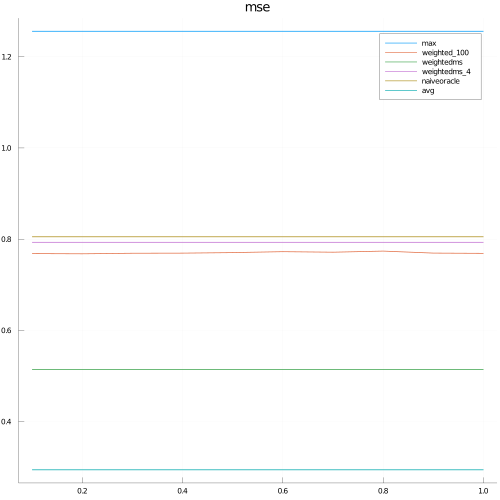

In [33]:
x = opt.Deltas
i = 1; plot(x, mse[:,i], label=estimator_names[i], linewidth=3, size=(2000,2000))
i = 2; plot!(x, mse[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(x, mse[:,i], label=estimator_names[i], linewidth=3) 
i = 4; plot!(x, mse[:,i], label=estimator_names[i], linewidth=3) 
i = 5; plot!(x, mse[:,i], label=estimator_names[i], linewidth=3) 
i = 6; plot!(x, mse[:,i], label=estimator_names[i], linewidth=3)  
title!("mse")